# House Price Prediction

# Introduction:

*   In this project, various features of houses are used to predict their estimated value.
*   Exploratory data analysis, data preprocessing, and multiple regression models are used to find the best one.
*   Finally, the performance of the models are evaluated using common regression metrics.



# Dataset Description:

* id: Unique ID for each house.
* estimated_value: The price the house is predicted to sell for (target variable).
* living_units: The number of bedrooms in the house.
* baths: The number of bathrooms in the house.
* interior_size: The interior living space size in square feet.
* lot_size: The size of the lot in square feet.
* num_floors: The number of floors in the house.
* has_waterfront: Whether the house has a waterfront view.
* scenic_view: Whether the house has a scenic view.
* house_condition: The overall condition of the house, with higher values indicating better condition.
* year_built: The year the house was built.

In [118]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

house = pd.read_csv("House_Sales_Dataset.csv")

# Task 1: Exploratory Data Analysis (EDA)
* Visualize the distribution of the target variable (`estimated_value`).
* Create scatter plots or histograms to explore relationships between features like `living_units`, `baths`, `interior_size`, and `estimated_value`.
* Use a correlation heatmap to observe correlations between features and `estimated_value`.

In [119]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               21613 non-null  int64  
 1   date             21613 non-null  object 
 2   estimated_value  21613 non-null  float64
 3   living_units     21613 non-null  int64  
 4   baths            21613 non-null  float64
 5   interior_size    21613 non-null  int64  
 6   lot_size         21613 non-null  int64  
 7   num_floors       21613 non-null  float64
 8   has_waterfront   21613 non-null  object 
 9   scenic_view      21613 non-null  object 
 10  house_condition  21613 non-null  int64  
 11  grade            21613 non-null  int64  
 12  sqft_above       21613 non-null  int64  
 13  year_built       21613 non-null  int64  
 14  zipcode          21613 non-null  int64  
 15  lat              21613 non-null  float64
 16  long             21613 non-null  float64
 17  sqft_living1

array([[<Axes: xlabel='living_units', ylabel='living_units'>,
        <Axes: xlabel='baths', ylabel='living_units'>,
        <Axes: xlabel='interior_size', ylabel='living_units'>,
        <Axes: xlabel='estimated_value', ylabel='living_units'>],
       [<Axes: xlabel='living_units', ylabel='baths'>,
        <Axes: xlabel='baths', ylabel='baths'>,
        <Axes: xlabel='interior_size', ylabel='baths'>,
        <Axes: xlabel='estimated_value', ylabel='baths'>],
       [<Axes: xlabel='living_units', ylabel='interior_size'>,
        <Axes: xlabel='baths', ylabel='interior_size'>,
        <Axes: xlabel='interior_size', ylabel='interior_size'>,
        <Axes: xlabel='estimated_value', ylabel='interior_size'>],
       [<Axes: xlabel='living_units', ylabel='estimated_value'>,
        <Axes: xlabel='baths', ylabel='estimated_value'>,
        <Axes: xlabel='interior_size', ylabel='estimated_value'>,
        <Axes: xlabel='estimated_value', ylabel='estimated_value'>]],
      dtype=object)

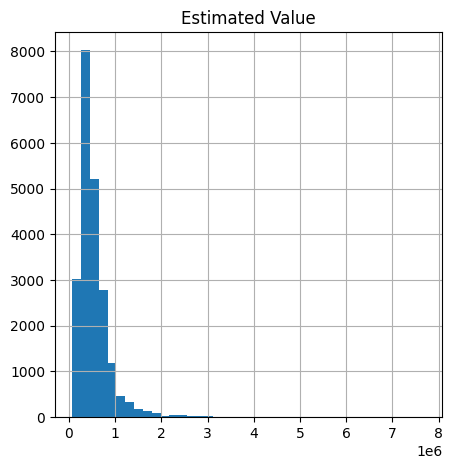

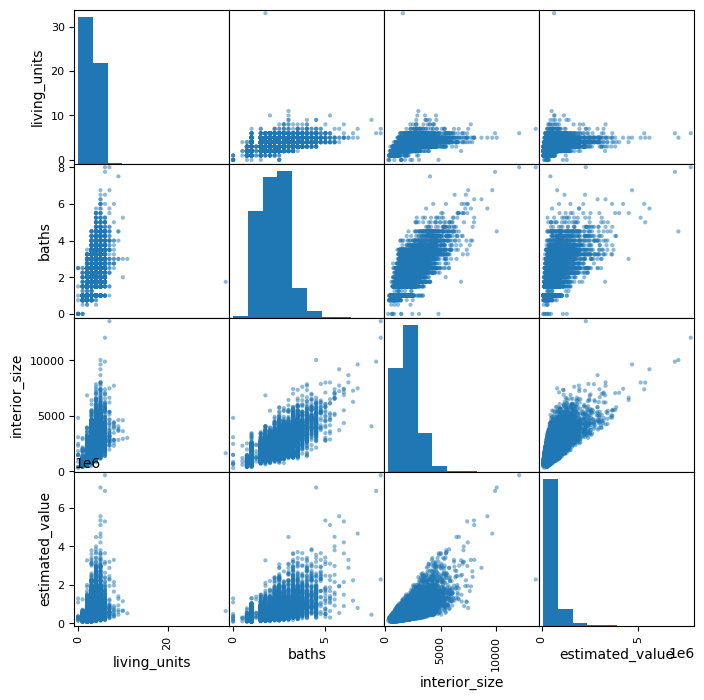

In [120]:
# EDA code

from pandas.plotting import scatter_matrix
import seaborn as sns

house['estimated_value'].hist(bins=40, figsize=(5,5)) # histogram to display distr of est val
plt.title("Estimated Value")

attr = ['living_units', 'baths', 'interior_size', 'estimated_value']
scatter_matrix(house[attr], figsize=(8,8)) # scatter plots


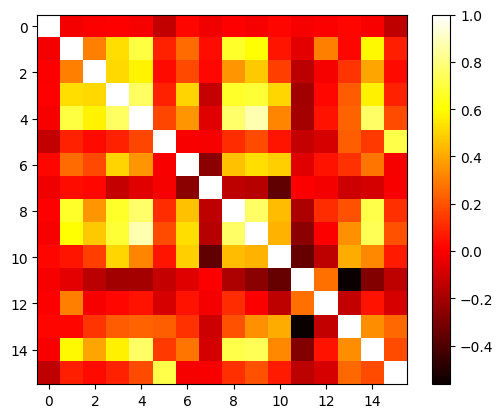

<Axes: >

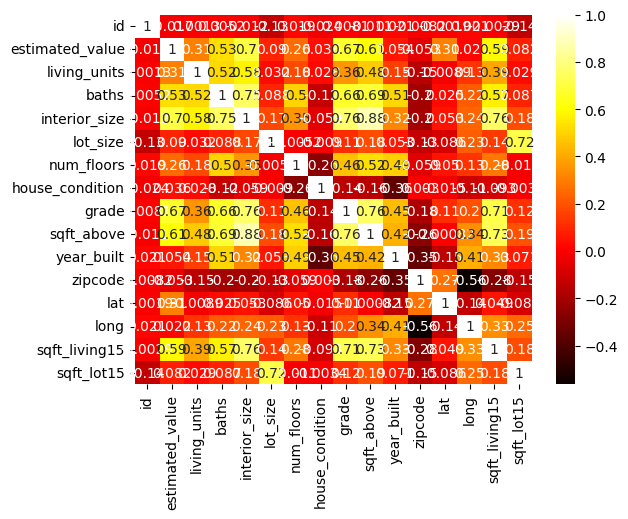

In [121]:
# EDA code

corr_martix = house.corr(numeric_only=True) # corr matrix with numeric vals only

plt.imshow(corr_martix, cmap="hot")
plt.colorbar()
plt.show()

sns.heatmap(corr_martix, annot=True, cmap="hot") # sns heatmap with labels

# Task 2: Data Preprocessing with Pipelines and Feature Extraction
* Pipeline used for handling missing values, scaling, and feature extraction.
* ColumnTransformer used for applying different transformations to numeric and categorical features.

In [122]:
# Data preprocessing code

house.drop(['date', 'grade', 'sqft_above', 'zipcode', 'lat', 'long', 'sqft_living15','sqft_lot15'], axis=1, inplace=True) # remove unneccesary columns
house.info() # show remaining columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               21613 non-null  int64  
 1   estimated_value  21613 non-null  float64
 2   living_units     21613 non-null  int64  
 3   baths            21613 non-null  float64
 4   interior_size    21613 non-null  int64  
 5   lot_size         21613 non-null  int64  
 6   num_floors       21613 non-null  float64
 7   has_waterfront   21613 non-null  object 
 8   scenic_view      21613 non-null  object 
 9   house_condition  21613 non-null  int64  
 10  year_built       21613 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 1.8+ MB


In [123]:
house['estimated_value'].head()

,estimated_value
0,221900.0
1,538000.0
2,180000.0
3,604000.0
4,510000.0


In [124]:
# Categorize
house['est_val'] = pd.cut(house['estimated_value'], bins = [0, 100000, 250000, 500000, 750000, 1000000, np.inf], labels = [1, 2, 3, 4, 5, 6])

# Use new column in stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit

split_obj = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split_obj.split(house, house['est_val']):
  strat_train_set = house.iloc[train_index]
  strat_test_set = house.iloc[test_index]

In [125]:
strat_train_set = strat_train_set.copy()
strat_test_set = strat_test_set.copy()

strat_train_set.drop("est_val", axis=1, inplace=True)
strat_test_set.drop("est_val", axis=1, inplace=True)

In [126]:
# Get attributes to be preprocessed and added to the pipeline

from sklearn.pipeline import Pipeline

train = strat_train_set.drop('estimated_value', axis=1)
train_labels = strat_train_set['estimated_value'].copy()

test = strat_test_set.drop('estimated_value', axis=1)
test_labels = strat_test_set['estimated_value'].copy()


num_attribs = list(train.drop(['has_waterfront', 'scenic_view'], axis=1)) # create list without categorical features present
num_std_attribs = [num_attribs[0]] + num_attribs[3:8]
num_maxmin_attribs = ["interior_size", "lot_size"] # Minmax
cat_attributes = ['has_waterfront', 'scenic_view'] # Categorical features


In [127]:
train_labels

,estimated_value
8424,700000.0
2191,605000.0
13290,272450.0
4652,238000.0
9791,216500.0
...,...
8291,315000.0
6181,289950.0
2019,275000.0
3127,176500.0


array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'estimated_value'}>,
        <Axes: title={'center': 'living_units'}>],
       [<Axes: title={'center': 'baths'}>,
        <Axes: title={'center': 'interior_size'}>,
        <Axes: title={'center': 'lot_size'}>],
       [<Axes: title={'center': 'num_floors'}>,
        <Axes: title={'center': 'house_condition'}>,
        <Axes: title={'center': 'year_built'}>]], dtype=object)

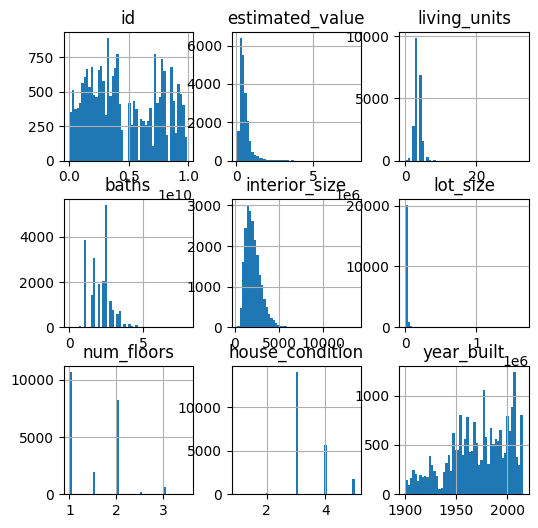

In [128]:
house.hist(bins=50, figsize=(6,6))

In [129]:
num_attribs

['id',
 'living_units',
 'baths',
 'interior_size',
 'lot_size',
 'num_floors',
 'house_condition',
 'year_built']

In [130]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer(strategy='median')

my_imputer

num_std_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                              ('stdscaler', StandardScaler())
])

num_minmax_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                              ('minmaxscaler', MinMaxScaler())
])

cat_pipeline = Pipeline([('onehotencoder', OneHotEncoder())
])

In [131]:
from sklearn.compose import ColumnTransformer

full_transformer = ColumnTransformer([('num_stdpreprocessing', num_std_pipeline, num_std_attribs),
                                      ('num_minmaxpreprocessing', num_minmax_pipeline, num_maxmin_attribs),
                                      ('cat_preprocessing', cat_pipeline, cat_attributes),
                                      ])

# Task 3: Train Regression Models
Train 5 regression models within a pipeline:
* Linear Regression
* Decision Tree
* Random Forest
* Ridge Regression
* Lasso Regression

In [132]:
# Model training code

# Linear Regression

from sklearn.linear_model import LinearRegression

p1_full_pipeline = Pipeline([
                        ('all_column_transformation', full_transformer),
                        ('linear_regression', LinearRegression())
                      ])

In [133]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor

p2_full_pipeline = Pipeline([('all_column_transformation', full_transformer),
                        ('decision_tree', DecisionTreeRegressor())
                      ])

In [134]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor as RFR

p3_full_pipeline = Pipeline([('all_column_transformation', full_transformer),
               ("RFR_model", RFR())
               ])

In [135]:
# Ridge and Lasso
from sklearn.linear_model import Ridge, Lasso

p4_full_pipeline = Pipeline([('all_column_transformation', full_transformer),
               ("ridge_regression", Ridge())
               ])

p5_full_pipeline = Pipeline([('all_column_transformation', full_transformer),
               ("lasso_regression", Lasso(max_iter=100000))
               ])

# Task 4: Hyperparameter Tuning with GridSearchCV
* Apply GridSearchCV to two models for hyperparameter tuning.

In [136]:
# Grid search for RFR

from sklearn.model_selection import GridSearchCV

# Grid for RFR
param_grid = [
    # 12 combinations of hyperparameters
    {'RFR_model__n_estimators': [3, 10, 30], 'RFR_model__max_features': [2, 4, 6, 8]},
    # 6 combinations with bootstrap set as False
    {'RFR_model__bootstrap': [False], 'RFR_model__n_estimators': [3, 10], 'RFR_model__max_features': [2, 3, 4]},
  ]

# New object
grid_search = GridSearchCV(p3_full_pipeline, param_grid, cv=5)
grid_search.fit(train, train_labels)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('all_column_transformation',
                                        ColumnTransformer(transformers=[('num_stdpreprocessing',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('stdscaler',
                                                                                          StandardScaler())]),
                                                                         ['id',
                                                                          'interior_size',
                                                                          'lot_size',
                                                                          'num_floors',
                                                                          'house_condition',
                                                                          'year_built']),
                                                                        ('num_minmaxpreprocessing',
                                                                         Pipeline(steps=[('imp...
                                                                          'lot_size']),
                                                                        ('cat_preprocessing',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['has_waterfront',
                                                                          'scenic_view'])])),
                                       ('RFR_model', RandomForestRegressor())]),
             param_grid=[{'RFR_model__max_features': [2, 4, 6, 8],
                          'RFR_model__n_estimators': [3, 10, 30]},
                         {'RFR_model__bootstrap': [False],
                          'RFR_model__max_features': [2, 3, 4],
                          'RFR_model__n_estimators': [3, 10]}])

In [137]:
# GridSearchCV code

# Grid search for Ridge

param_grid_reg = [
    {'ridge_regression__alpha': [0.1, 1.0, 10.0]},  # Alpha values to test
]

# GridSearchCV object
grid_search2 = GridSearchCV(p4_full_pipeline, param_grid_reg, cv=5)

# Fit the GridSearchCV object to the training data
grid_search2.fit(train, train_labels)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('all_column_transformation',
                                        ColumnTransformer(transformers=[('num_stdpreprocessing',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('stdscaler',
                                                                                          StandardScaler())]),
                                                                         ['id',
                                                                          'interior_size',
                                                                          'lot_size',
                                                                          'num_floors',
                                                                          'house_condition',
                                                                          'year_built']),
                                                                        ('num_minmaxpreprocessing',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('minmaxscaler',
                                                                                          MinMaxScaler())]),
                                                                         ['interior_size',
                                                                          'lot_size']),
                                                                        ('cat_preprocessing',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder())]),
                                                                         ['has_waterfront',
                                                                          'scenic_view'])])),
                                       ('ridge_regression', Ridge())]),
             param_grid=[{'ridge_regression__alpha': [0.1, 1.0, 10.0]}])

# Task 5: Model Evaluation
* Evaluate the performance of each model using RMSE, MAE, and R-squared.
* Compare the models

In [138]:
# Model evaluation code

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

def fit_and_print(p, train_set, train_labels, test_set, test_labels):
  p.fit(train_set, train_labels)
  train_preds = p.predict(train_set)
  test_preds = p.predict(test_set)

  print("Training Error: " + str(mean_absolute_error(train_preds, train_labels)))
  print("Test Error: " + str(mean_absolute_error(test_preds, test_labels)))

  print("Training RMSE: " + str(np.sqrt(mean_squared_error(train_preds, train_labels))))
  print("Test RMSE: " + str(np.sqrt(mean_squared_error(test_preds, test_labels))))

  print("R2 score: " + str(r2_score(test_labels, test_preds)))  # Fixed order


In [139]:
# Linear Regression

fit_and_print(p1_full_pipeline, train, train_labels, test, test_labels)

Training Error: 157204.0119714951
Test Error: 155741.41286158975
Training RMSE: 236834.08369836948
Test RMSE: 235568.68889086234
R2 score: 0.6059037421094478


In [140]:
lin_reg = p1_full_pipeline
lin_reg.fit(train, train_labels)

pred = lin_reg.predict(test)

print("Est Values from linear regression:")
print(pred)

Est Values from linear regression:
[ 801225.21134643  172681.60574578  384239.72717093 ... 1059090.89053488
  405432.97165638  495426.10581478]


Decision tree - overfitting

In [141]:
# Decision Tree

fit_and_print(p2_full_pipeline, train, train_labels, test, test_labels)

Training Error: 881.1257952573742
Test Error: 184612.0213971779
Training RMSE: 9512.72185108487
Test RMSE: 303394.7932352732
R2 score: 0.34629255956617355


In [142]:
dec_tree = p2_full_pipeline
dec_tree.fit(train, train_labels)

pred2 = dec_tree.predict(test)

print("Est Values from decision tree:")
print(pred2)

Est Values from decision tree:
[745000. 185000. 475000. ... 847700. 612000. 315000.]


RFR = smallest test error and best R2

In [143]:
# Random Forest Regressor

fit_and_print(p3_full_pipeline, train, train_labels, test, test_labels)

Training Error: 50653.43882772958
Test Error: 133657.478660443
Training RMSE: 79311.25389940714
Test RMSE: 217585.95463850073
R2 score: 0.6637758555181803


In [144]:
rfr = p3_full_pipeline
rfr.fit(train, train_labels)

pred3 = rfr.predict(test)

print("Est Values from rfr:")
print(pred3)

Est Values from rfr:
[ 769279.01  256824.45  365949.49 ... 1106665.6   436954.08  411157.06]


In [145]:
# Ridge

fit_and_print(p4_full_pipeline, train, train_labels, test, test_labels)

Training Error: 157201.66581627543
Test Error: 155743.7055562008
Training RMSE: 236834.12795932838
Test RMSE: 235575.46989442778
R2 score: 0.6058810531298093


In [146]:
ridge = p4_full_pipeline
ridge.fit(train, train_labels)

pred4 = ridge.predict(test)

print("Est Values from ridge:")
print(pred4)

Est Values from ridge:
[ 801238.20657007  172684.04341499  384239.51389262 ... 1059100.61594244
  405445.27037621  495439.4137867 ]


In [147]:
# Lasso

fit_and_print(p5_full_pipeline, train, train_labels, test, test_labels)

Training Error: 157203.84094061423
Test Error: 155741.74651703477
Training RMSE: 236834.08412836713
Test RMSE: 235569.6312192516
R2 score: 0.6059005891536247


In [148]:
lasso = p5_full_pipeline
lasso.fit(train, train_labels)

pred5 = lasso.predict(test)

print("Est Values from lasso:")
print(pred5)

Est Values from lasso:
[ 801227.98683542  172681.55644128  384238.79275094 ... 1059092.16157119
  405434.91087245  495428.59429638]


# Conclusion:
* Summary of findings and interesting insights from the analysis.

This project aimed to find the estimated_value of houses based on various features. During the process, exploratory data analysis, data processing, model training, hyperparameter tuning, and evaluation via regression metrics were employed.

---


The distribution of the targeted value 'estimated_value' was visualized with a histogram. Because the graph is skewed right, stratified shuffle split was used when making the training and testing data sets. A scatterplot was used to show the relationship between the target and other selected features.


The strat_test and strat_train sets retrieved were used to get train, test, and label variables to be used in our evaluation method.  Categorical and numerical features were also selected to be input into the pipeline.


GridSearch was used on both RFR and Ridge for hyperparameter tuning


The models evaluated were Linear Regressor, Decision Tree Regressor, Random Forest Regressor, Ridge Ression, and Lasso Regression. **The best performing model is the Random Forest Regressor** due to its test mean absolute error value being the lowest of the five models, as well as its R^2 score being 0.66. **The poorest performing model is decision tree** which has characteristics of overfitting and a low R2 score. The training set performs well with a low MAE while the testing set is exceptionally larger. I also noticed that lasso and ridge yielded very similar prediction values.



---

Something I found interesting from the data was the heatmap and seeing the correlations between the target value and various other features. For example, with the map, we are able to see the strongest correlation between estimated value is interior_size at 0.7 which shows that the size of a home has a significant correlation on the house's value. On the other hand, a weaker correlation with estimated_value was num_floors showing that this feature isn't that significant in predicitng house price/value.

